<a href="https://colab.research.google.com/github/totminaekaterina/Coursework_multitasking_learning/blob/main/%D0%9A%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%84%D0%B8%D0%BA%D0%B0%D1%86%D0%B8%D1%8F_%D1%82%D0%B5%D0%BA%D1%81%D1%82%D0%BE%D0%B2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 52.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 70.6 MB/s eta 0:00:00


In [2]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import numpy as np
import pandas as pd
from random import randint
import torch
from torch.utils.data import (TensorDataset,
                              DataLoader,
                              RandomSampler)

from tensorflow.keras.preprocessing.sequence import pad_sequences

from transformers import AutoConfig, AutoModelForSequenceClassification
from transformers import (AutoTokenizer,
                          AutoModelForCausalLM,
                          Trainer,
                          TrainingArguments,
                          TrainerCallback,
                          AdamW,
                          get_linear_schedule_with_warmup)

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [5]:
device = 'cuda'
device = torch.device(device)

print(device.type)
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))

cuda
Tesla T4


In [6]:
!pip install chardet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
import chardet
with open('/content/train.csv', 'rb') as rawdata:
    result = chardet.detect(rawdata.read(100000))
result

{'encoding': 'UTF-8-SIG', 'confidence': 1.0, 'language': ''}

In [9]:
df = pd.read_csv('/content/train.csv', encoding='UTF-8-SIG', sep=';')
# Размер нашей выборки
df.shape

(758509, 3)

In [10]:
df.sample(5)

,Unnamed: 0,name,category_1
16954,422031,"""Сургутнефтегаз"" потратит 10 миллиардов долларов",Все
689836,532625,Убийство саудовцами главы правительства хусито...,Конфликты
563025,597437,Пьяный пассажир угнал микроавтобус со взлетной...,Общество
268402,335935,Две челябинских школьницы выжили после прыжка ...,Все
298332,359997,Житель Сочи украл десять километров электрокабеля,Все


In [11]:
df.category_1.unique()

array(['Все', 'Музыка', 'Кино', 'Офис', 'Украина', 'Деловой климат',
       'Футбол', 'Пресса', 'Бизнес', 'Космос', 'Город', 'Первая мировая',
       'Coцсети', 'Искусство', 'Гаджеты', 'Инструменты', 'Стиль', 'Рынки',
       'Интернет', 'Общество', 'Явления', 'Политика', 'Происшествия',
       'Еда', 'Экономика', 'Часы', 'Госэкономика', 'Игры', 'Деньги',
       'Летние виды', 'ТВ и радио', 'Вещи', 'Бокс и ММА', 'Культура',
       'Россия', 'Мир', 'Конфликты', 'Белоруссия', 'Закавказье', 'Мнения',
       'Люди', 'Регионы', 'Достижения', 'Прибалтика', 'Следствие и суд',
       'Преступность', 'Квартира', 'Дача', 'Молдавия', 'Средняя Азия',
       'Криминал', 'Театр', 'Звери', 'Мемы', 'Москва', 'Наука', 'Книги',
       'Дом', 'Техника', 'Софт', 'Из жизни', 'Реклама', 'События',
       'Внешний вид', 'Автобизнес', 'Оружие', 'Финансы компаний',
       'Социальная сфера', 'Хоккей', 'Английский футбол',
       'Мировой бизнес', 'Полиция и спецслужбы', 'Жизнь', 'Вкусы',
       'История', 'Виру

In [12]:
# Присвоим каждой категории индекс, чтобы подавать в модель
category_index = {i[1]:i[0] for i in enumerate(df.category_1.unique())}
# обратное преобразование - индекс метки в текст, этот словарь нам понадобится 
# после обучения для большей наглядности, чтобы видеть, к какой категории товар 
# отнесён моделью
category_index_reverce = {i[0]:i[1] for i in enumerate(df.category_1.unique())}

In [13]:
category_index

{'Все': 0,
 'Музыка': 1,
 'Кино': 2,
 'Офис': 3,
 'Украина': 4,
 'Деловой климат': 5,
 'Футбол': 6,
 'Пресса': 7,
 'Бизнес': 8,
 'Космос': 9,
 'Город': 10,
 'Первая мировая': 11,
 'Coцсети': 12,
 'Искусство': 13,
 'Гаджеты': 14,
 'Инструменты': 15,
 'Стиль': 16,
 'Рынки': 17,
 'Интернет': 18,
 'Общество': 19,
 'Явления': 20,
 'Политика': 21,
 'Происшествия': 22,
 'Еда': 23,
 'Экономика': 24,
 'Часы': 25,
 'Госэкономика': 26,
 'Игры': 27,
 'Деньги': 28,
 'Летние виды': 29,
 'ТВ и радио': 30,
 'Вещи': 31,
 'Бокс и ММА': 32,
 'Культура': 33,
 'Россия': 34,
 'Мир': 35,
 'Конфликты': 36,
 'Белоруссия': 37,
 'Закавказье': 38,
 'Мнения': 39,
 'Люди': 40,
 'Регионы': 41,
 'Достижения': 42,
 'Прибалтика': 43,
 'Следствие и суд': 44,
 'Преступность': 45,
 'Квартира': 46,
 'Дача': 47,
 'Молдавия': 48,
 'Средняя Азия': 49,
 'Криминал': 50,
 'Театр': 51,
 'Звери': 52,
 'Мемы': 53,
 'Москва': 54,
 'Наука': 55,
 'Книги': 56,
 'Дом': 57,
 'Техника': 58,
 'Софт': 59,
 'Из жизни': 60,
 'Реклама': 61,
 '

In [14]:
category_index_reverce

{0: 'Все',
 1: 'Музыка',
 2: 'Кино',
 3: 'Офис',
 4: 'Украина',
 5: 'Деловой климат',
 6: 'Футбол',
 7: 'Пресса',
 8: 'Бизнес',
 9: 'Космос',
 10: 'Город',
 11: 'Первая мировая',
 12: 'Coцсети',
 13: 'Искусство',
 14: 'Гаджеты',
 15: 'Инструменты',
 16: 'Стиль',
 17: 'Рынки',
 18: 'Интернет',
 19: 'Общество',
 20: 'Явления',
 21: 'Политика',
 22: 'Происшествия',
 23: 'Еда',
 24: 'Экономика',
 25: 'Часы',
 26: 'Госэкономика',
 27: 'Игры',
 28: 'Деньги',
 29: 'Летние виды',
 30: 'ТВ и радио',
 31: 'Вещи',
 32: 'Бокс и ММА',
 33: 'Культура',
 34: 'Россия',
 35: 'Мир',
 36: 'Конфликты',
 37: 'Белоруссия',
 38: 'Закавказье',
 39: 'Мнения',
 40: 'Люди',
 41: 'Регионы',
 42: 'Достижения',
 43: 'Прибалтика',
 44: 'Следствие и суд',
 45: 'Преступность',
 46: 'Квартира',
 47: 'Дача',
 48: 'Молдавия',
 49: 'Средняя Азия',
 50: 'Криминал',
 51: 'Театр',
 52: 'Звери',
 53: 'Мемы',
 54: 'Москва',
 55: 'Наука',
 56: 'Книги',
 57: 'Дом',
 58: 'Техника',
 59: 'Софт',
 60: 'Из жизни',
 61: 'Реклама',
 6

In [15]:
# Переведём все метки датасета в числа
sentences = df.name.values
labels = [category_index[i] for i in df.category_1.values]

In [16]:
# Каждому предложению (названию товара) теперь соответсвует не название категории, а её индекс:
sentences[22], labels[22]

(' ""Локомотив"" и ""Спартак""', 0)

In [17]:
# Проверим, что все данные корректны
assert len(sentences) == len(labels) == df.shape[0]

In [18]:
sentences = ['[CLS] ' + sentence + ' [SEP]' for sentence in sentences]

In [19]:
train_sentences, test_sentences, train_category, test_category = train_test_split(sentences, labels, test_size=0.005)

In [20]:
len(train_sentences), len(test_sentences)

(754716, 3793)

In [21]:
from transformers import BertTokenizer, ErnieForMaskedLM

tokenizer = BertTokenizer.from_pretrained("nghuyong/ernie-3.0-base-zh")
model = ErnieForMaskedLM.from_pretrained("nghuyong/ernie-3.0-base-zh")

In [22]:
tokenized_texts = [tokenizer.tokenize(sent) for sent in train_sentences]

In [23]:
# Посмотрим, что получилось
# Сомволы номеров отмечают то, что данный токен - продолжение слова
print(tokenized_texts[42])

['[CLS]', '[UNK]', '[UNK]', '[UNK]', 'в', '[UNK]', '[SEP]']


In [24]:
# ииндексы токенов
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

(array([7.23965e+05, 3.04330e+04, 2.06000e+02, 7.00000e+01, 2.40000e+01,
        1.00000e+01, 7.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([  3. ,  14.7,  26.4,  38.1,  49.8,  61.5,  73.2,  84.9,  96.6,
        108.3, 120. ]),
 <a list of 10 Patch objects>)

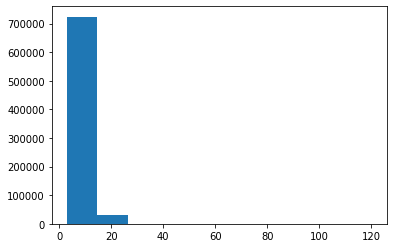

In [25]:
# Соберём все размеры последовательностей
lenths = [len(sent) for sent in tokenized_texts]
# Посмотрим, как они распределяются
plt.hist(lenths)

In [26]:
# Выравниваем датасет. Возьмём размер, равный 24
input_ids = pad_sequences(
    input_ids,
    # максимальная длина предложения
    maxlen=24,
    dtype='long',
    truncating='post',
    padding='post'
)

In [27]:

# Вот, что у нас в результате получилось
# Как видно, в этом примере меньше 24 токенов, поэтому в конец был добавлен паддинг
input_ids[42]
     

array([    1, 39979, 39979, 39979, 18147, 39979,     2,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0])

In [28]:

# Создадим маску внимания для каждого сэмпла нашей обучающей выборки.
# единицами отметим те токены, которые нужно учитывать при обучении и вычислении градиентов,
# нулями - те, которые следует пропустить.
attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

In [29]:

print(attention_masks[42])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [30]:
# каждая маска соответсвует своей последовательности
assert len(input_ids[42]) == len(attention_masks[42])

In [31]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(
    input_ids, train_category, 
    random_state=42,
    test_size=0.1
)

train_masks, validation_masks, _, _ = train_test_split(
    attention_masks,
    input_ids,
    random_state=42,
    test_size=0.1
)

In [32]:
assert len(train_inputs) == len(train_labels) == len(train_masks)
assert len(validation_inputs) == len(validation_labels) == len(validation_masks)

In [33]:
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)

validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)

In [34]:
from torch.utils.data import SequentialSampler

In [35]:
# специальная обёртка для работы с Тензор-датасетами, в Pytorch есть и другие,
# также можно и свою обёртку написать, для нашей же задачи вполне хватит уже существующих
# в библиотеке инструментов. Используя их мы существенно сокращаем свой код.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(
    train_data,
    # Данные по батчам разбиваем произвольно с помощью RandomSampler
    sampler=RandomSampler(train_data),
    batch_size=64
)
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_dataloader = DataLoader(
    validation_data,
    sampler=SequentialSampler(validation_data),
    batch_size=64
)

In [36]:
config = AutoConfig.from_pretrained('nghuyong/ernie-3.0-base-zh',
                                    num_labels=len(category_index),
                                    id2label=category_index_reverce,
                                    label2id=category_index)

In [37]:
#Загружаем модель, передаём ей наш конфиг
model = AutoModelForSequenceClassification.from_pretrained('nghuyong/ernie-3.0-base-zh', config=config)

Some weights of the model checkpoint at nghuyong/ernie-3.0-base-zh were not used when initializing ErnieForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing ErnieForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ErnieForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ErnieForSequenceClassification were not initialized from the model checkpoint at nghuyong/ernie-3.0-base-zh and are newly initialized: ['classifier.weight', 'cla

In [38]:
# Отправим на видеокарту, заодно посмотрим архитектуру нашего Берта
model.cuda()

ErnieForSequenceClassification(
  (ernie): ErnieModel(
    (embeddings): ErnieEmbeddings(
      (word_embeddings): Embedding(40000, 768, padding_idx=0)
      (position_embeddings): Embedding(2048, 768)
      (token_type_embeddings): Embedding(4, 768)
      (task_type_embeddings): Embedding(3, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ErnieEncoder(
      (layer): ModuleList(
        (0): ErnieLayer(
          (attention): ErnieAttention(
            (self): ErnieSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ErnieSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
     

In [39]:
# Гипепараметры модели. Их можно изменять
param_optimizer = list(model.named_parameters())

In [40]:
# Можно посмотреть или изменить. Но нам этого не нужно, инициализируем лишь функцию
# оптимизации. В качестве оптимизатора будем использовать оптимизированный 
# Adam (adaptive moment estimation)
# for name, _ in param_optimizer:
#     print(name)

no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [41]:
%%time
train_loss_set = []
train_loss = 0

# Переводим модель в training mode
model.train()

for step, batch in enumerate(train_dataloader):
    # Переводим данные на видеокарту
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    
    # Обнуляем градиенты
    optimizer.zero_grad()
    
    # Прогоняем данные по слоям нейросети
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

    train_loss_set.append(loss[0].item())  
    
    # Обратный прогон
    loss[0].backward()
    
    # Шаг
    optimizer.step()

    # Обновляем loss
    train_loss += loss[0].item()
    #print(f'Loss: {loss[0].item()}')
print('*'*20)
print(f'Лосс на обучении: {train_loss / len(train_dataloader)}')

********************
Лосс на обучении: 1.9156002038129871
CPU times: user 34min 1s, sys: 15min 54s, total: 49min 55s
Wall time: 50min 27s


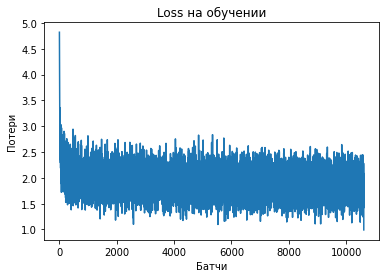

In [42]:
# посмотрим, как обучалась наша модель
plt.plot(train_loss_set)
plt.title("Loss на обучении")
plt.xlabel("Батчи")
plt.ylabel("Потери")
plt.show()

In [43]:
%time

# Переводим модель в evaluation mode
model.eval()

valid_preds, valid_labels = [], []

for batch in validation_dataloader:   
    # добавляем батч для вычисления на GPU
    batch = tuple(t.to(device) for t in batch)
    
    b_input_ids, b_input_mask, b_labels = batch

    
    
    # Вычислять градиенты не нужно
    with torch.no_grad():
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # Перемещаем логиты и метки на CPU
    logits = logits[0].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    batch_preds = np.argmax(logits, axis=1)
    batch_labels = label_ids #np.concatenate(label_ids)     
    valid_preds.extend(batch_preds)
    valid_labels.extend(batch_labels)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 6.91 µs


Сохранение и загрузка дообученной модели

In [52]:
from google.colab import drive
drive.mount('/content/Model_09.02.23')

Mounted at /content/Model_09.02.23


In [55]:
model.save_pretrained('/content/Model_09.02.23/MyDrive/Model 09.02')
tokenizer.save_pretrained('/content/Model_09.02.23/MyDrive/Model 09.02')

('/content/Model_09.02.23/MyDrive/Model 09.02/tokenizer_config.json',
 '/content/Model_09.02.23/MyDrive/Model 09.02/special_tokens_map.json',
 '/content/Model_09.02.23/MyDrive/Model 09.02/vocab.txt',
 '/content/Model_09.02.23/MyDrive/Model 09.02/added_tokens.json',
 '/content/Model_09.02.23/MyDrive/Model 09.02/tokenizer.json')

In [56]:
# config
config = AutoConfig.from_pretrained('/content/Model_09.02.23/MyDrive/Model 09.02')
# tokenizer
tokenizer = AutoTokenizer.from_pretrained('/content/Model_09.02.23/MyDrive/Model 09.02', pad_to_max_length=True)
# model
model = AutoModelForSequenceClassification.from_pretrained('/content/Model_09.02.23/MyDrive/Model 09.02', config=config)

In [ ]:
model

In [49]:
%%time

model.to('cpu')
model.eval()

# Выберем несколько случайных названий товаров
skus = [randint(1, len(df)) for p in range(0, 10)]
for sku in skus:
    ground_truth = df.iloc[sku]['category_1']
    sku_title = df.iloc[sku]['name']
    tokens = tokenizer.encode(sku_title, add_special_tokens=True)
    tokens_tensor = torch.tensor([tokens])
    with torch.no_grad():
        logits = model(tokens_tensor)
    # Логиты по каждой категории
    logits = logits[0].detach().numpy()
    # Выбираем наиболее вероятную категорию товара
    predicted_class = np.argmax(logits, axis=1)

    print(f'Наименование товара: {sku_title}')
    print(f'Предсказанная категория: {category_index_reverce[predicted_class[0]]}')
    print(f'Истинная категория: {ground_truth}')
    print()

Наименование товара: Итальянский остров Стромболи стал необитаемым
Предсказанная категория: Все
Истинная категория: Все

Наименование товара: Чипы флэш-памяти уменьшили второй раз за неделю
Предсказанная категория: Все
Истинная категория: Все

Наименование товара: Цукерберг не позволил девелоперу заработать на своем имени
Предсказанная категория: Все
Истинная категория: Все

Наименование товара: Песков объяснил приостановку соглашения с США об утилизации плутония
Предсказанная категория: Все
Истинная категория: Политика

Наименование товара: Британские школьники отправили Черчилля на Луну
Предсказанная категория: Все
Истинная категория: Все

Наименование товара: Комиссия ПАСЕ подтвердила полномочия российской делегации
Предсказанная категория: Все
Истинная категория: Все

Наименование товара: Турецкий сухогруз снес опоры строящегося моста через Керченский пролив
Предсказанная категория: Все
Истинная категория: Происшествия

Наименование товара: СМИ узнали о неготовности аэропортов Егип